### Task 3: Customer Segmentation / Clustering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
customers_df = pd.read_csv(r'C:\Users\Bhatta\Downloads\Customers.csv')
products_df = pd.read_csv(r'C:\Users\Bhatta\Downloads\Products.csv')
transactions_df =  pd.read_csv(r'C:\Users\Bhatta\Downloads\Transactions.csv')

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler

In [4]:
# Merge datasets
customer_transactions = pd.merge(transactions_df, customers_df, on="CustomerID", how="left")
customer_transactions = pd.merge(customer_transactions, products_df, on="ProductID", how="left")

In [5]:
# Feature engineering
customer_features = customer_transactions.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    distinct_products=("ProductID", "nunique"),
    total_quantity=("Quantity", "sum")
).reset_index()

customer_features = pd.merge(customer_features, customers_df[["CustomerID", "Region"]], on="CustomerID", how="left")
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

In [6]:
# Prepare data for clustering
X = customer_features.drop(columns=["CustomerID"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Apply KMeans clustering and evaluate using DBI and silhouette score
cluster_results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, labels)
    silhouette_avg = silhouette_score(X_scaled, labels)
    cluster_results.append({
        "n_clusters": n_clusters,
        "DBI": db_index,
        "Silhouette": silhouette_avg,
    })

In [8]:
# Determine the best number of clusters
best_cluster = min(cluster_results, key=lambda x: x["DBI"])

In [9]:
# Apply KMeans with the optimal number of clusters
optimal_kmeans = KMeans(n_clusters=best_cluster["n_clusters"], random_state=42)
customer_features["Cluster"] = optimal_kmeans.fit_predict(X_scaled)


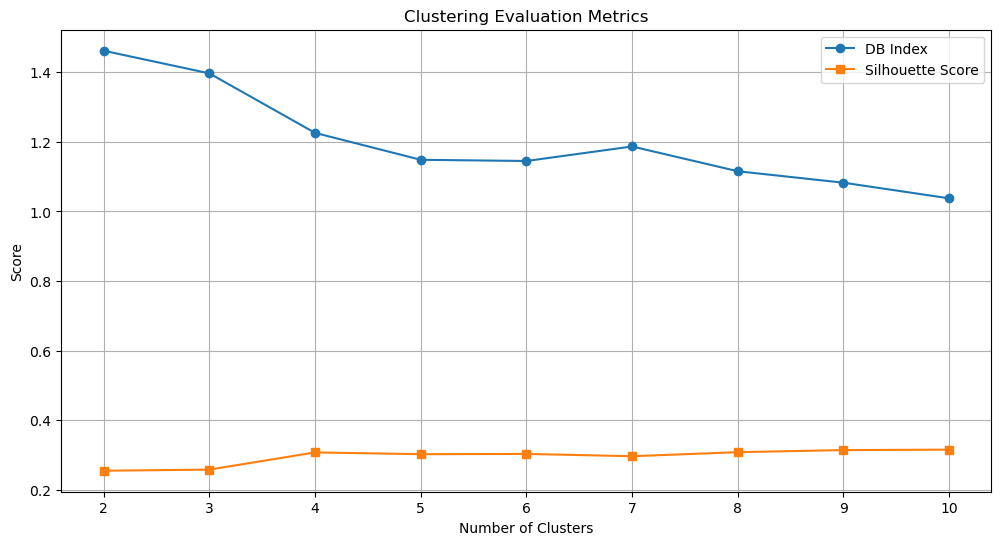

In [10]:
# Visualize DBI and silhouette scores
results_df = pd.DataFrame(cluster_results)
plt.figure(figsize=(12, 6))
plt.plot(results_df["n_clusters"], results_df["DBI"], marker="o", label="DB Index")
plt.plot(results_df["n_clusters"], results_df["Silhouette"], marker="s", label="Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Clustering Evaluation Metrics")
plt.legend()
plt.grid()
plt.show()

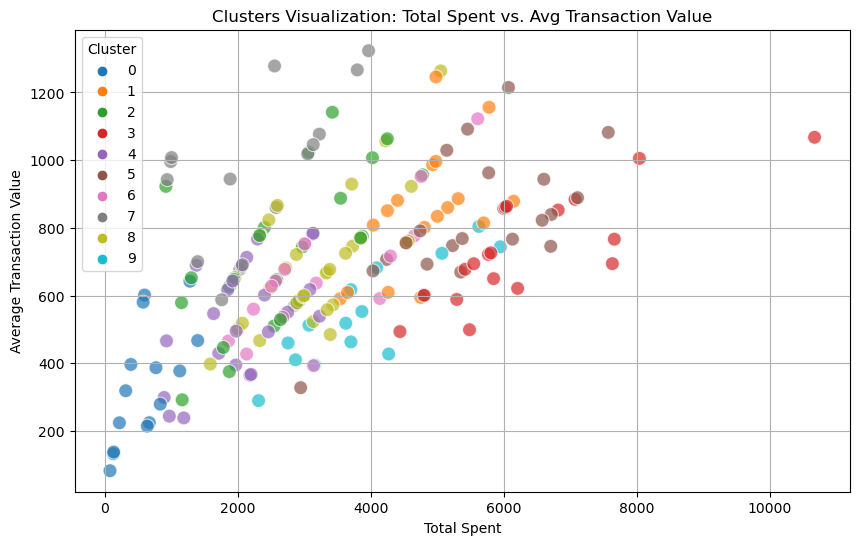

In [11]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_features,
    x="total_spent",
    y="avg_transaction_value",
    hue="Cluster",
    palette="tab10",
    s=100,
    alpha=0.7
)
plt.title("Clusters Visualization: Total Spent vs. Avg Transaction Value")
plt.xlabel("Total Spent")
plt.ylabel("Average Transaction Value")
plt.legend(title="Cluster")
plt.grid()
plt.show()

In [12]:
# Summarize clusters
cluster_summary = customer_features.groupby("Cluster").mean()
pd.DataFrame(cluster_summary)

,total_spent,total_transactions,avg_transaction_value,distinct_products,total_quantity,Region_Europe,Region_North America,Region_South America
Cluster,,,,,,,,
0,614.394000,1.800000,337.578667,1.800000,3.533333,0.133333,0.133333,0.533333
1,4792.131111,5.833333,842.013358,5.777778,16.055556,1.000000,0.000000,0.000000
2,2685.889615,3.884615,710.264045,3.884615,10.230769,0.000000,1.000000,0.000000
3,6367.055000,8.722222,736.880743,8.222222,23.166667,0.111111,0.222222,0.000000
4,2101.315833,4.041667,537.536687,3.958333,9.000000,1.000000,0.000000,0.000000
5,5545.575909,6.954545,817.059878,6.590909,19.454545,0.000000,0.000000,1.000000
6,3223.288889,4.944444,658.735433,4.833333,12.777778,0.000000,0.000000,0.000000
7,2295.272000,2.400000,960.933556,2.333333,6.466667,0.266667,0.000000,0.000000
8,3141.587241,4.620690,694.194144,4.517241,11.206897,0.000000,0.000000,1.000000
